In [50]:
import re
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=10,6

In [2]:
df=pd.read_csv(R'D:\CDAC\Content\NLP\SMS Spam Collection.csv', sep='\t', names=["label","message"])
print(df.shape)
df.head()

(5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.isna().sum()

label      0
message    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


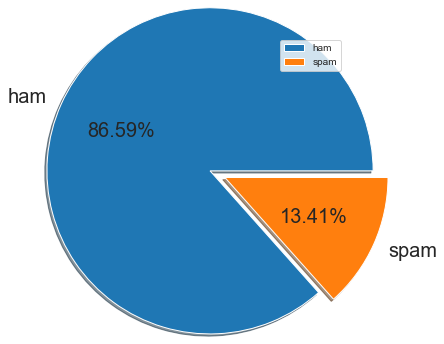

In [51]:
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, explode=[0,0.15], shadow=True, radius=1.5, autopct='%0.2f%%', textprops={'fontsize': 20})
plt.legend(loc=0)
plt.show()

Data preprocessing:

In [6]:
ps=PorterStemmer()
corpus=[]
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['message'][i]).lower().split()
    review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
print(len(corpus))
print(corpus[:20])

5572
['go jurong point crazi avail bugi n great world la e buffet cine got amor wat', 'ok lar joke wif u oni', 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli', 'u dun say earli hor u c alreadi say', 'nah think goe usf live around though', 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv', 'even brother like speak treat like aid patent', 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun', 'winner valu network custom select receivea prize reward claim call claim code kl valid hour', 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free', 'gonna home soon want talk stuff anymor tonight k cri enough today', 'six chanc win cash pound txt csh send cost p day day tsandc appli repli hl info', 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw', 'search right word thank breather promis 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
X_2=tfidf.fit_transform(corpus).toarray()
print(X_2.shape)

(5572, 6296)


TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors as model can process only numerical data.

In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

To overcome this , we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

In [8]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
Y=lb.fit_transform(df['label'])

In [13]:
X_2[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
Y[:5]

array([0, 0, 1, 0, 0])

Cross validation:

In [16]:
models=[LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, C=1.0),
        SVC(kernel='linear', C=0.01, probability=True),
        RandomForestClassifier(n_estimators=100, criterion='gini' ,bootstrap=True),
        MultinomialNB(alpha=1.0, fit_prior=True)]

In [17]:
scores=[]
def classify(model, x, y):
    score=cross_val_score(model, x, y, cv=KFold(n_splits=5))
    scores.append(score.mean())
    print("Model Accuracy for KFold cross validation:", round(np.mean(score)*100,3))
    return

In [18]:
for model in models:
    print(model,':')
    classify(model, X_2, Y)
    print('\n')

LogisticRegression(max_iter=500) :
Model Accuracy for KFold cross validation: 96.231


SVC(C=0.01, kernel='linear', probability=True) :
Model Accuracy for KFold cross validation: 86.594


RandomForestClassifier() :
Model Accuracy for KFold cross validation: 97.613


MultinomialNB() :
Model Accuracy for KFold cross validation: 96.787




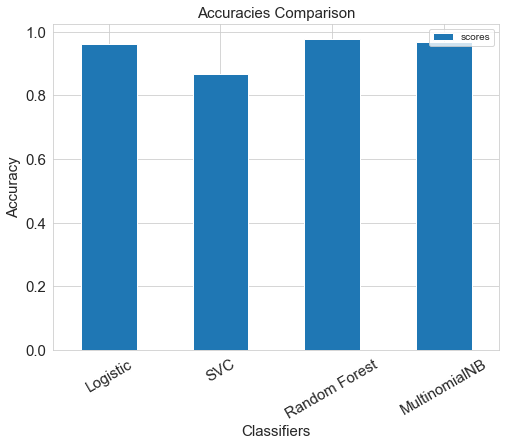

In [42]:
ss=pd.Series(scores).to_frame(name='scores')
ss.index=['Logistic', 'SVC', 'Random Forest', 'MultinomialNB']
ss.plot(kind='bar')
plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Classifiers', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracies Comparison', fontsize=15)
plt.show()

Hence, Random Forest scores best in KFold cross validation with 5 splits.

Creating a model:

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2, Y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4179, 6296) (1393, 6296) (4179,) (1393,)


In [41]:
rfc=models[2].fit(X_train, y_train)
print("Training Accuracy: ", round(rfc.score(X_train, y_train)*100,3))
print("Testing Accuracy: ", round(rfc.score(X_test, y_test)*100,3))

Training Accuracy:  100.0
Testing Accuracy:  98.277


Prediction and evaluation:

In [43]:
y_pred=rfc.predict(X_test)

In [60]:
def evaluation(a, b):
    print('Confusion Matrix - \n')
    print(confusion_matrix(a, b), '\n')
    print('Classification Report - \n')
    print(classification_report(a, b))
    plt.rcParams['figure.figsize']=12,4
    precision, recall, _= precision_recall_curve(a, b)
    plt.plot(recall, precision)
    plt.xlabel('Recall',fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.title('Precision VS Recall', fontsize=15)
    plt.show()
    fpr, tpr, _ = roc_curve(a, b)
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.title('ROC Curve', fontsize=15)
    plt.show()

Confusion Matrix - 

[[1208    0]
 [  24  161]] 

Classification Report - 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       1.00      0.87      0.93       185

    accuracy                           0.98      1393
   macro avg       0.99      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



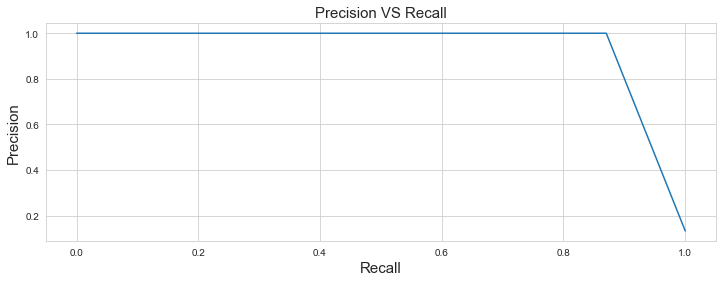

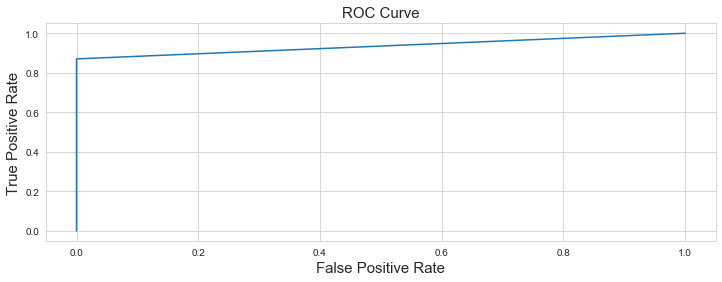

In [61]:
evaluate_model=evaluation(y_test, y_pred)

Model Testing:

In [62]:
mess = ['you are a WINNER!! To claim 1000$ call 99999999', "I am ready to invest in dating service"]
output = rfc.predict(tfidf.transform(mess))

for i ,m in enumerate(mess):
    print(m, ' == ', 'ham' if output[i]==0 else 'spam')

you are a WINNER!! To claim 1000$ call 99999999  ==  spam
I am ready to invest in dating service  ==  ham


The model generalizes the given input accurately.